In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import wandb
import xarray as xr

from functools import partial
from dask.diagnostics import ProgressBar

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker

import seaborn as sns

from fme_diags.utils import (
    get_run_kwargs, get_wandb_path,
    load_config, load_global_time_mean_metrics,
    melt_training_steps, open_autoregressive_inference, 
    open_reference,
)

_ = xr.set_options(keep_attrs=True)

plt.rcParams['text.usetex'] = True

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jamesd (ai2cm). Use `wandb login --relogin` to force relogin


True

In [178]:
FULL_RETRAINING = "42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema"

ACE_FV3GFS = "retrain-30e-rs1-10yr-ema"

ZERO_SHOT = "fv3gfs_zero_shot-run00"
REF = "42-years-training-set-reference"

INF_RUN_LABELS = {
    FULL_RETRAINING: "ACE-EAMv2",
    ACE_FV3GFS: "ACE-FV3GFS",
    ZERO_SHOT: "ACE-FV3GFS zero-shot",
    REF: "EAMv2 noise floor",
}

In [3]:
config = load_config("./preds.yaml")
run_kwargs = get_run_kwargs(config, FULL_RETRAINING)
ds = open_autoregressive_inference(**run_kwargs)

In [4]:
OUTDIR = "figs/2024-05-01-ACE-EAMv2-time-mean"
os.makedirs(OUTDIR, exist_ok=True)

In [179]:
PRECIP = "surface_precipitation_rate"
PS = "PS"
OLR = "FLUT"
OSR = "top_of_atmos_upward_shortwave_flux"  
TWP_ADV = "tendency_of_total_water_path_due_to_advection"
Q = [f"specific_total_water_{i}" for i in range(8)]

PS_FACTOR = 0.01 
PS_UNITS = "hPa"

PRECIP_FACTOR = 86400.0
PRECIP_UNITS = "mm/day"

Q_FACTOR = 1e3
Q_UNITS = "g/kg"

FLUX_UNITS = "W/m$^2$"

variables = config["variables"]
prognostic_vars = variables["labels"]["prognostic"]
diagnostic_vars = variables["labels"]["diagnostic"]
all_vars = {
    **prognostic_vars,
    **diagnostic_vars,
}

fv3gfs_variables = variables["fv3gfs"]
all_vars_fv3gfs = {
    **fv3gfs_variables["prognostic"],
    **fv3gfs_variables["diagnostic"],
}
fv3gfs_vars_dict = {v: all_vars[k] for k, v in all_vars_fv3gfs.items()}

wandb_inf_keys_stems = config["wandb_metrics"]["inference"]

all_units = {varname: ds[varname].units for varname in all_vars.keys()}
all_units[PRECIP] = PRECIP_UNITS
all_units[TWP_ADV] = PRECIP_UNITS
all_units[PS] = PS_UNITS

for q_lev in Q:
    all_units[q_lev] = Q_UNITS

for k, v in all_units.items():
    if v == "W/m2":
        all_units[k] = FLUX_UNITS
        
all_units = pd.DataFrame.from_dict(all_units, orient="index", columns=["units"])

def rescale_variable(x, factor: float, units=None):
    x = x * factor
    if isinstance(x, xr.DataArray):
        x = x.assign_attrs(units=units)
    return x

UNIT_CONVERSIONS = {
    PRECIP: partial(rescale_variable, factor=PRECIP_FACTOR, units=PRECIP_UNITS),
    TWP_ADV: partial(rescale_variable, factor=PRECIP_FACTOR, units=PRECIP_UNITS),
    PS: partial(rescale_variable, factor=PS_FACTOR, units=PS_UNITS),
    **{
        f"{Q_STEM}_{i}": partial(rescale_variable, factor=Q_FACTOR, units=Q_UNITS)
        for i in range(8)
    }
}

FV3GFS_CONVERSIONS = {all_vars_fv3gfs[k]: UNIT_CONVERSIONS[k] for k in UNIT_CONVERSIONS.keys()}

FV3GFS_TO_EAMV2_VARS = dict(zip(all_vars_fv3gfs.values(), all_vars_fv3gfs.keys()))

In [6]:
api = wandb.Api()

In [180]:
# %%time

inf_runs = {
    key: api.run(get_wandb_path(config, key))
    for key in INF_RUN_LABELS.keys()
}

inf_rmse = {
    key: load_global_time_mean_metrics(
        wandb_run=run, 
        keys_stem=wandb_inf_keys_stems["rmse"],
        vars_dict=all_vars, 
        run_label=INF_RUN_LABELS[key],
        apply_funcs=UNIT_CONVERSIONS,
    )
    for key, run in inf_runs.items() if key != ACE_FV3GFS
}

inf_rmse[ACE_FV3GFS] = load_global_time_mean_metrics(
    wandb_run=inf_runs[ACE_FV3GFS],
    keys_stem=wandb_inf_keys_stems["rmse"],
    vars_dict=fv3gfs_vars_dict,
    run_label=INF_RUN_LABELS[ACE_FV3GFS],
    apply_funcs=FV3GFS_CONVERSIONS,
).rename(columns=FV3GFS_TO_EAMV2_VARS)

inf_rmse_df = pd.concat(inf_rmse.values())
inf_rmse_long = melt_training_steps(inf_rmse_df)

inf_rmse_long

,,,value
run,_step,variable,
ACE-EAMv2,14596,PS,0.606210
ACE-FV3GFS zero-shot,14596,PS,17.575348
EAMv2 noise floor,14596,PS,0.405713
ACE-FV3GFS,14600,PS,1.034889
ACE-EAMv2,14596,U_0,1.253934
...,...,...,...
ACE-FV3GFS,14600,surface_precipitation_rate,0.465387
ACE-EAMv2,14596,tendency_of_total_water_path_due_to_advection,0.396759
ACE-FV3GFS zero-shot,14596,tendency_of_total_water_path_due_to_advection,2.053545


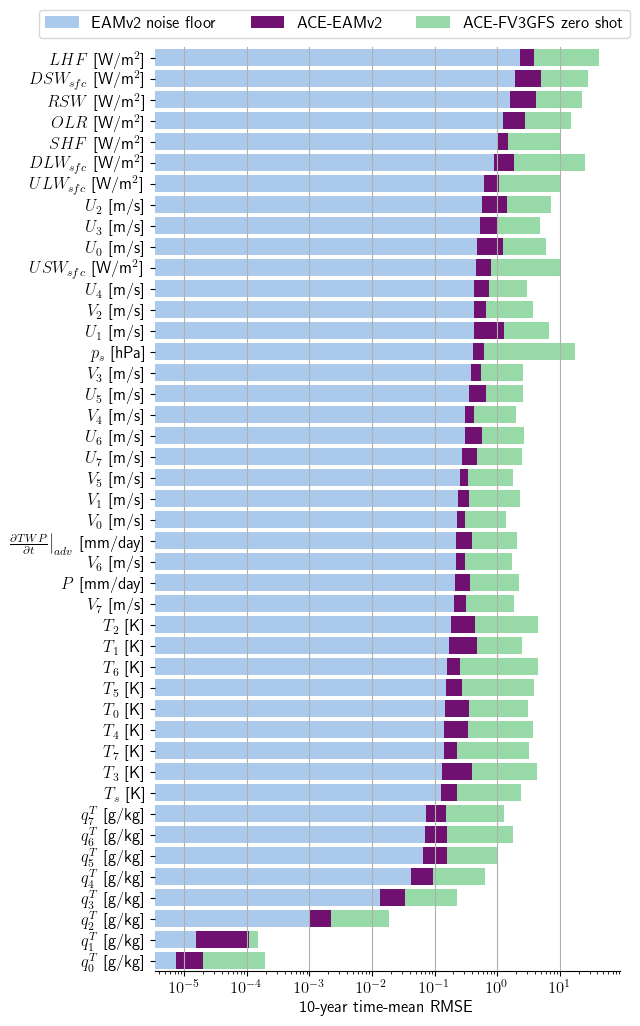

In [118]:
df_to_plot = inf_rmse_long.reset_index("_step", drop=True).unstack("run")
df_to_plot.columns = df_to_plot.columns.droplevel()
# df_to_plot = df_to_plot.sort_values(INF_RUN_LABELS[ZERO_SHOT], ascending=False)
df_to_plot = df_to_plot.sort_values(INF_RUN_LABELS[REF], ascending=False)
df_to_plot = df_to_plot.join(
    all_units, on="variable"
).join(
    pd.DataFrame.from_dict(all_vars, orient="index", columns=["title"]), 
    on="variable"
)
df_to_plot["title_units"] = df_to_plot["title"] + " [" + df_to_plot["units"] + "]"

fig, ax = plt.subplots(figsize=(6, 12))

sns.set_color_codes("pastel")

# Plot 
sns.barplot(
    x=INF_RUN_LABELS[ZERO_SHOT], 
    y="title_units", data=df_to_plot,
    color="g", label=INF_RUN_LABELS[ZERO_SHOT],
)

# Plot 
sns.barplot(
    x=INF_RUN_LABELS[FULL_RETRAINING], 
    y="title_units", data=df_to_plot,
    color="purple", label=INF_RUN_LABELS[FULL_RETRAINING],
)

# Plot 
sns.barplot(
    x=INF_RUN_LABELS[REF], 
    y="title_units", data=df_to_plot,
    color="b", label=INF_RUN_LABELS[REF],
)

# Add a legend and informative axis label
ax.legend(
    ncol=3, loc=(-0.25, 1.01), frameon=True, reverse=True
)
ax.set(
    ylabel="", xscale="log",
    xlabel="10-year time-mean RMSE"
)
ax.grid(axis="x")

sns.despine(left=True, bottom=False)

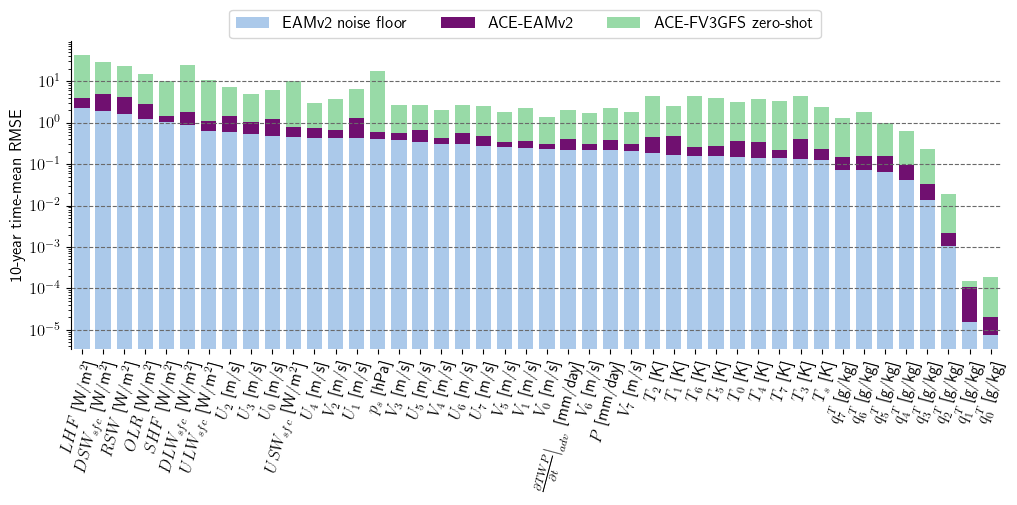

In [181]:
df_to_plot = inf_rmse_long.reset_index("_step", drop=True).unstack("run")
df_to_plot.columns = df_to_plot.columns.droplevel()
# df_to_plot = df_to_plot.sort_values(INF_RUN_LABELS[ZERO_SHOT], ascending=False)
df_to_plot = df_to_plot.sort_values(INF_RUN_LABELS[REF], ascending=False)
df_to_plot = df_to_plot.join(
    all_units, on="variable"
).join(
    pd.DataFrame.from_dict(all_vars, orient="index", columns=["title"]), 
    on="variable"
)
df_to_plot["title_units"] = df_to_plot["title"] + " [" + df_to_plot["units"] + "]"

fig, ax = plt.subplots(figsize=(12, 4))

sns.set_color_codes("pastel")

width, gap = 1.8, 0.6

# Plot 
sns.barplot(
    y=INF_RUN_LABELS[ZERO_SHOT], 
    x="title_units", data=df_to_plot,
    color="g", label=INF_RUN_LABELS[ZERO_SHOT],
    width=width, gap=gap,
)

# Plot 
sns.barplot(
    y=INF_RUN_LABELS[FULL_RETRAINING], 
    x="title_units", data=df_to_plot,
    color="purple", label=INF_RUN_LABELS[FULL_RETRAINING],
    width=width, gap=gap,
)

# Plot 
sns.barplot(
    y=INF_RUN_LABELS[REF], 
    x="title_units", data=df_to_plot,
    color="b", label=INF_RUN_LABELS[REF],
    width=width, gap=gap,
)

# Add a legend and informative axis label
ax.legend(
    ncol=3, loc=(0.17, 1.01), frameon=True, reverse=True
)
ax.set(
    ylabel="10-year time-mean RMSE", yscale="log",
    xlabel=""
)

ax.grid(axis="y", color="dimgray", linestyle="--")

plt.setp(ax.get_xticklabels(), rotation=75, ha="right",
         rotation_mode="anchor")

sns.despine(left=False, bottom=True)

In [183]:
fig.savefig(os.path.join(OUTDIR, "global_time_mean_rmses.pdf"), bbox_inches="tight")

In [ ]:
df_to_plot = inf_rmse_long.reset_index("_step", drop=True).unstack("run")
df_to_plot.columns = df_to_plot.columns.droplevel()
# df_to_plot = df_to_plot.sort_values(INF_RUN_LABELS[ZERO_SHOT], ascending=False)
df_to_plot = df_to_plot.sort_values(INF_RUN_LABELS[REF], ascending=False)
df_to_plot = df_to_plot.join(
    all_units, on="variable"
).join(
    pd.DataFrame.from_dict(all_vars, orient="index", columns=["title"]), 
    on="variable"
)
df_to_plot["title_units"] = df_to_plot["title"] + " [" + df_to_plot["units"] + "]"

fig, ax = plt.subplots(figsize=(12, 3))

sns.set_color_codes("pastel")

width, gap = 1.3, 0.4

# Plot 
sns.barplot(
    y=INF_RUN_LABELS[ZERO_SHOT], 
    x="title_units", data=df_to_plot,
    color="g", label=INF_RUN_LABELS[ZERO_SHOT],
    width=width, gap=gap,
)

# Plot 
sns.barplot(
    y=INF_RUN_LABELS[FULL_RETRAINING], 
    x="title_units", data=df_to_plot,
    color="purple", label=INF_RUN_LABELS[FULL_RETRAINING],
    width=width, gap=gap,
)

# Plot 
sns.barplot(
    y=INF_RUN_LABELS[REF], 
    x="title_units", data=df_to_plot,
    color="b", label=INF_RUN_LABELS[REF],
    width=width, gap=gap,
)

# Add a legend and informative axis label
ax.legend(
    ncol=3, loc=(0.17, 1.01), frameon=True, reverse=True
)
ax.set(
    ylabel="10-year time-mean RMSE", yscale="log",
    xlabel=""
)
ax.grid(axis="y")

plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
         rotation_mode="anchor")

sns.despine(left=False, bottom=True)

In [51]:
inf_df = inf_rmse_long.join(all_units, on="variable").join(
    pd.DataFrame.from_dict(all_vars, orient="index", columns=["title"]), 
    on="variable"
)
inf_df["title_units"] = inf_df["title"] + " [" + inf_df["units"] + "]"

/global/homes/j/jpduncan/.conda/envs/e3sm-v2-fme/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


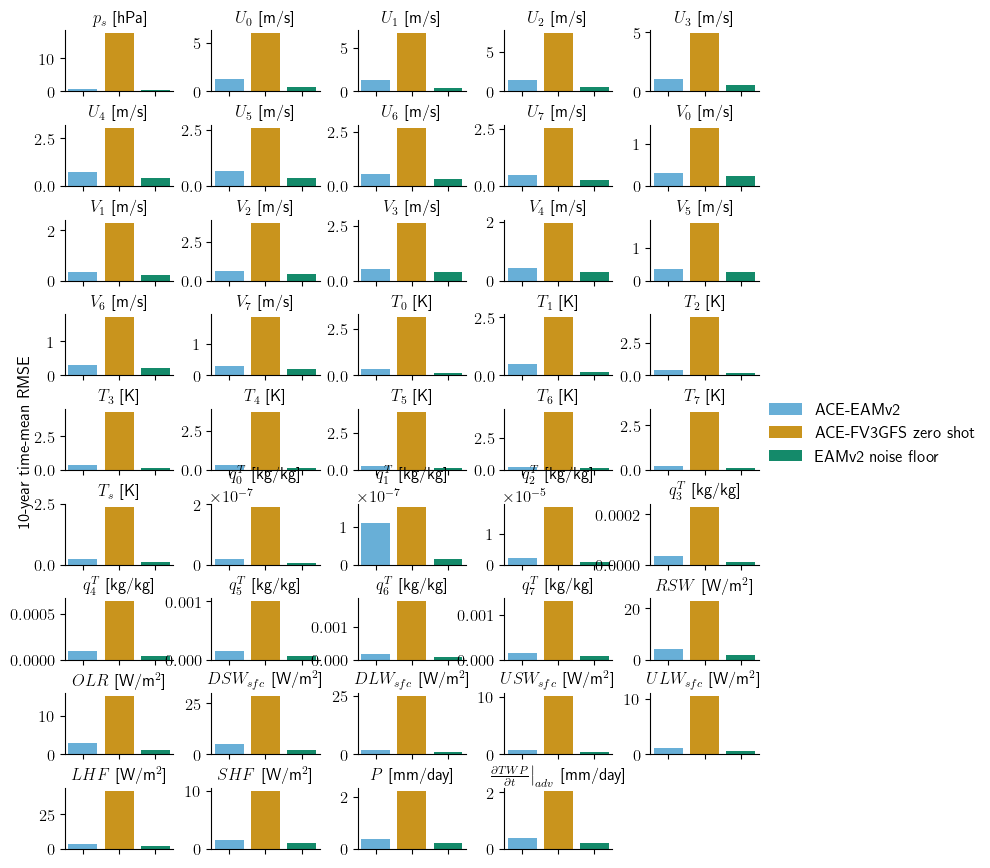

In [52]:
df_to_plot = inf_df.iloc[inf_df.index.get_level_values("run") != INF_RUN_LABELS[ACE_FV3GFS]]
# df_to_plot = df_to_plot.iloc[df_to_plot.index.get_level_values("run") != INF_RUN_LABELS[ACE_FV3GFS]]

# label_order = [INF_RUN_LABELS[x] for x in (ACE_FV3GFS, FULL_RETRAINING, REF)]

g = sns.catplot(
    df_to_plot, 
    kind="bar", x="run", y="value", col="title_units", hue="run", col_wrap=5,
    height=1, aspect=1.5, sharey=False, legend="full",
    # hue_order=label_order,
)

g.set_axis_labels("", "")
g.set_titles(col_template="{col_name}")

g.fig.text(0, 0.5, "10-year time-mean RMSE", 
           rotation="vertical", verticalalignment="center")

g._legend.set_title("")

g.set_xticklabels([])
g.figure.subplots_adjust(wspace=0.35, hspace=0.55)

plt.show()

In [53]:
REF_LABEL = INF_RUN_LABELS[REF]

inf_df_ref = inf_df.loc[REF_LABEL].reset_index("_step")
inf_df_ref = inf_df_ref.drop(
    ["_step", "units", "title", "title_units"], 
    axis=1,
)

inf_df_norm = inf_df.reset_index("_step", drop=True)
inf_df_norm = inf_df_norm.join(inf_df_ref, on="variable", lsuffix="", rsuffix="_ref")
inf_df_norm["value_norm"] = inf_df_norm["value"] / inf_df_norm["value_ref"]

channel_mean_norm = inf_df_norm.groupby("run").mean(numeric_only=True)
channel_mean_norm["title"] = "All channels (normalized)"
channel_mean_norm["units"] = "unitless"
channel_mean_norm["title_units"] = channel_mean_norm["title"]
channel_mean_norm["variable"] = "All"
channel_mean_norm = channel_mean_norm.set_index("variable", append=True)

# set "value" to the normalized version for plotting
channel_mean_norm["value"] = channel_mean_norm["value_norm"]

inf_df_norm = pd.concat([inf_df_norm, channel_mean_norm])

inf_df_norm

,,value,units,title,title_units,value_ref,value_norm
run,variable,,,,,,
ACE-EAMv2,PS,0.606210,hPa,$p_s$,$p_s$ [hPa],0.405713,1.494184
ACE-FV3GFS zero shot,PS,17.575348,hPa,$p_s$,$p_s$ [hPa],0.405713,43.319642
EAMv2 noise floor,PS,0.405713,hPa,$p_s$,$p_s$ [hPa],0.405713,1.000000
ACE-FV3GFS,PS,1.034889,hPa,$p_s$,$p_s$ [hPa],0.405713,2.550790
ACE-EAMv2,U_0,1.253934,m/s,$U_0$,$U_0$ [m/s],0.477066,2.628431
...,...,...,...,...,...,...,...
ACE-FV3GFS,tendency_of_total_water_path_due_to_advection,0.452118,mm/day,$\left . \frac{\partial TWP}{\partial t}\right...,$\left . \frac{\partial TWP}{\partial t}\right...,0.221117,2.044694
ACE-EAMv2,All,2.120852,unitless,All channels (normalized),All channels (normalized),0.407355,2.120852
ACE-FV3GFS,All,2.287777,unitless,All channels (normalized),All channels (normalized),0.407355,2.287777


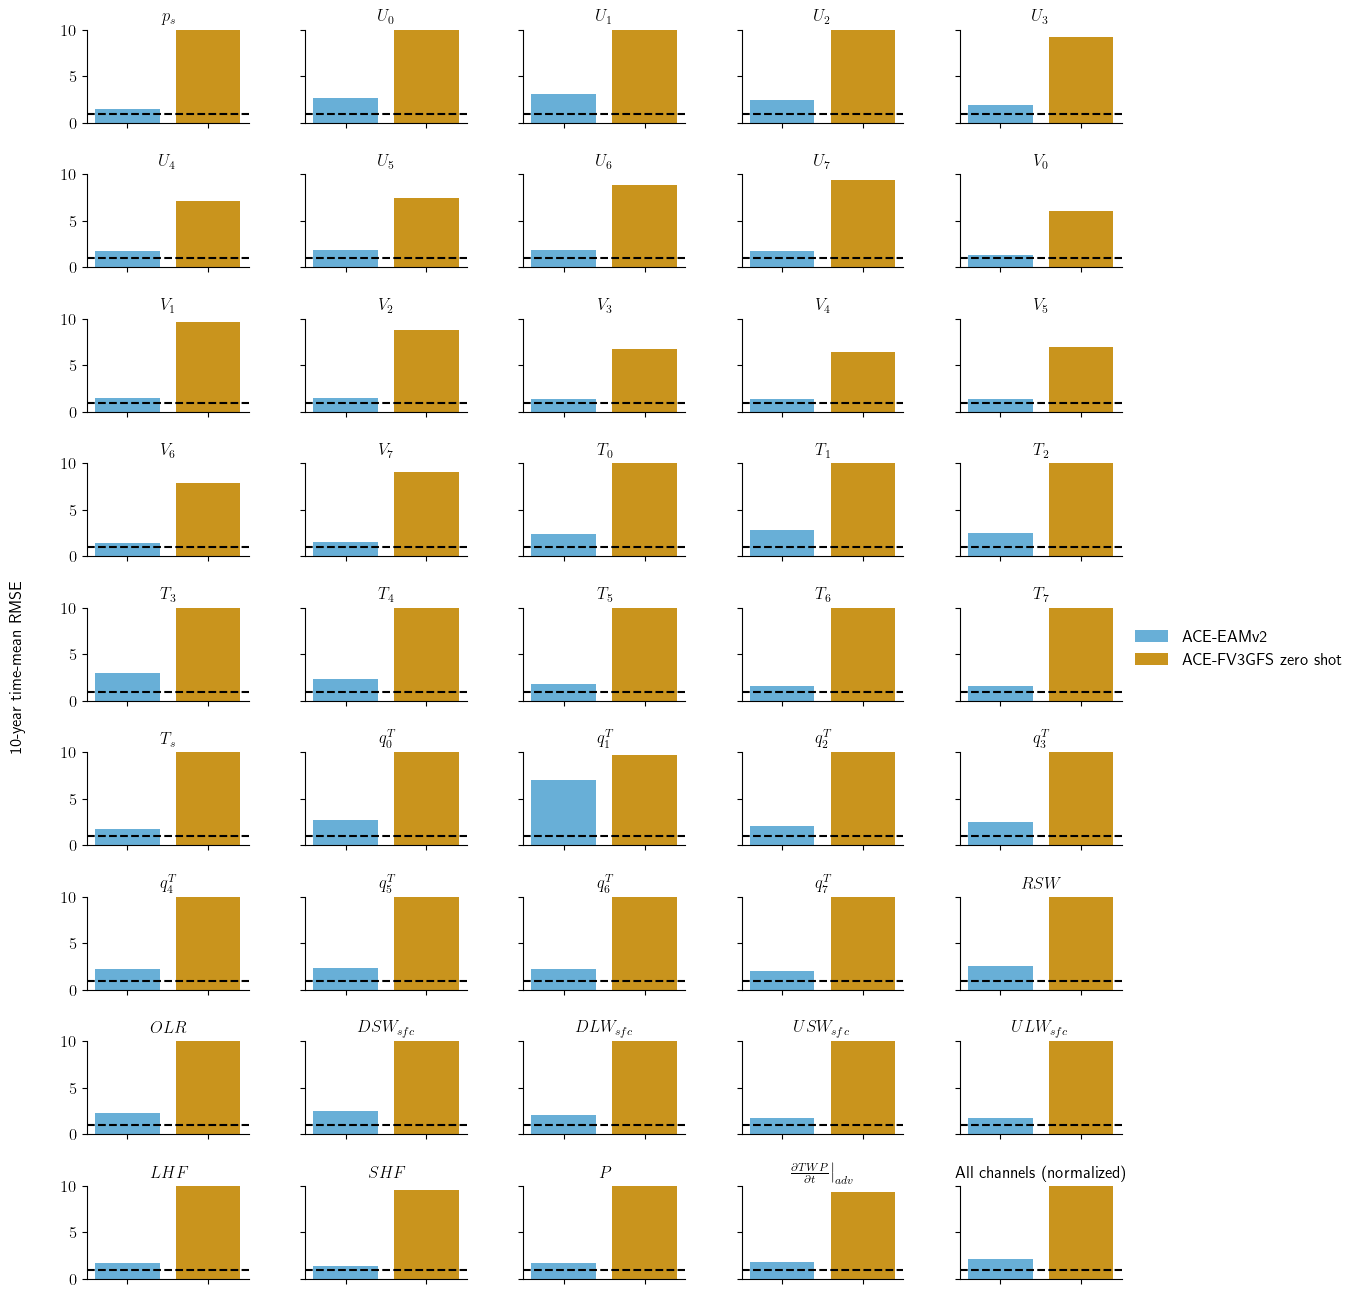

In [55]:
df_to_plot = inf_df_norm.iloc[inf_df_norm.index.get_level_values("run") != INF_RUN_LABELS[ACE_FV3GFS]]
df_to_plot = df_to_plot.iloc[df_to_plot.index.get_level_values("run") != INF_RUN_LABELS[REF]]

# df_to_plot = df_to_plot.iloc[df_to_plot.index.get_level_values("run") != INF_RUN_LABELS[ACE_FV3GFS]]

# label_order = [INF_RUN_LABELS[x] for x in (ACE_FV3GFS, FULL_RETRAINING, REF)]

g = sns.catplot(
    df_to_plot, 
    kind="bar", x="run", y="value_norm", col="title", hue="run", col_wrap=5,
    height=1.5, aspect=1.5, legend="full", # sharey=False, 
    # hue_order=label_order,
)

for ax in g.axes.flatten():
    ax.set_ylim(0, 10)
    ax.axhline(y=1.0, color="k", linestyle="--")

# g.set(yscale="log")
g.set_axis_labels("", "")
g.set_titles(col_template="{col_name}")

g.fig.text(0, 0.5, "10-year time-mean RMSE", 
           rotation="vertical", verticalalignment="center")

g._legend.set_title("")

g.set_xticklabels([])
g.figure.subplots_adjust(wspace=0.35, hspace=0.55)

plt.show()

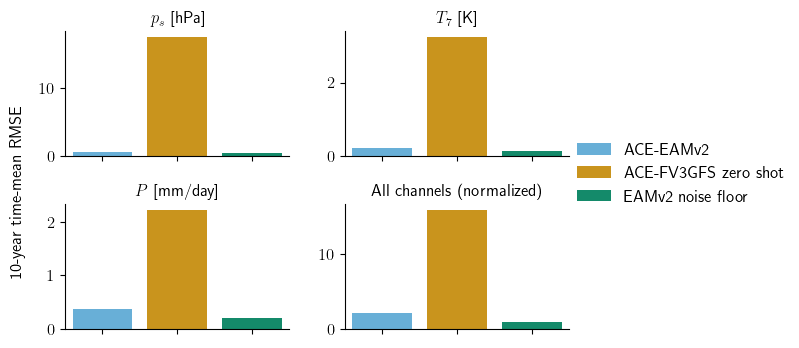

In [36]:
sns.set_context(rc={
    "font.size": 12,
})

vars_to_plot = ["All", "T_7", "surface_precipitation_rate", "PS"]

df_to_plot = inf_df_norm.loc[
    inf_df_norm.index.get_level_values("variable").isin(vars_to_plot)
]

df_to_plot = df_to_plot.loc[
    df_to_plot.index.get_level_values("run") != INF_RUN_LABELS[ACE_FV3GFS]
]

g = sns.catplot(
    df_to_plot,
    kind="bar",
    x="run", y="value", col="title", hue="run", col_wrap=2,
    height=2, aspect=1.5, sharey=False, legend="full",
)

g.set_axis_labels("", "")
g.set_titles(col_template="{col_name}")
g.fig.text(
    0.04, 0.5, "10-year time-mean RMSE", 
    rotation="vertical", verticalalignment="center"
)

g._legend.set_title("")

g.set_xticklabels([])
g.figure.subplots_adjust(wspace=0.25)

plt.show()

In [14]:
g.savefig(os.path.join(OUTDIR, "full_finetuning.pdf"), bbox_inches="tight")

In [61]:
%%time

inf_runs_fv3 = {
    key: api.run(get_wandb_path(config, key))
    for key in FV3GFS_INF_RUN_LABELS.keys()
}

inf_rmse_fv3 = {
    key: load_global_time_mean_metrics(
        wandb_run=run, 
        keys_stem=wandb_inf_keys_stems["rmse"],
        vars_dict=all_vars, 
        run_label=FV3GFS_INF_RUN_LABELS[key],
        apply_funcs=UNIT_CONVERSIONS,
    )
    for key, run in inf_runs_fv3.items()
}

inf_rmse_fv3_df = pd.concat(inf_rmse_fv3.values())
inf_rmse_fv3_long = melt_training_steps(inf_rmse_fv3_df)

inf_rmse_fv3_df

CPU times: user 38.8 ms, sys: 18.5 ms, total: 57.3 ms
Wall time: 944 ms


,,PS,U_0,U_1,U_2,U_3,U_4,U_5,U_6,U_7,V_0,...,top_of_atmos_upward_shortwave_flux,FLUT,FSDS,FLDS,surface_upward_shortwave_flux,surface_upward_longwave_flux,LHFLX,SHFLX,surface_precipitation_rate,tendency_of_total_water_path_due_to_advection
run,_step,,,,,,,,,,,,,,,,,,,,,
ACE-FV3GFS,14596,1.808828,1.710888,1.715136,2.533359,1.886607,1.245197,1.059534,0.980362,0.800601,0.484435,...,6.435694,3.158614,6.995996,2.950664,1.781235,2.347381,8.019211,3.229120,0.740310,0.707943
5-epoch finetuning,14596,14.621072,5.665852,5.407267,6.278041,4.221453,2.659274,2.427844,2.271773,1.850538,1.437940,...,16.903595,12.827410,23.195560,23.092911,10.102089,11.228965,32.204124,10.981621,2.259024,1.712812
10-epoch finetuning,14596,14.700057,7.504446,5.399600,5.931641,3.977004,2.653231,2.577206,2.369507,1.897591,1.431683,...,16.394743,12.451545,22.946947,23.691347,10.388535,10.825082,32.106373,11.069100,2.194088,1.652132
20-epoch finetuning,14596,14.787379,6.946623,5.436738,5.926711,4.092941,2.727531,2.615420,2.388302,1.924248,1.540969,...,16.118746,12.741355,22.947845,23.563442,10.363053,10.520896,32.528084,11.232071,2.217171,1.654754


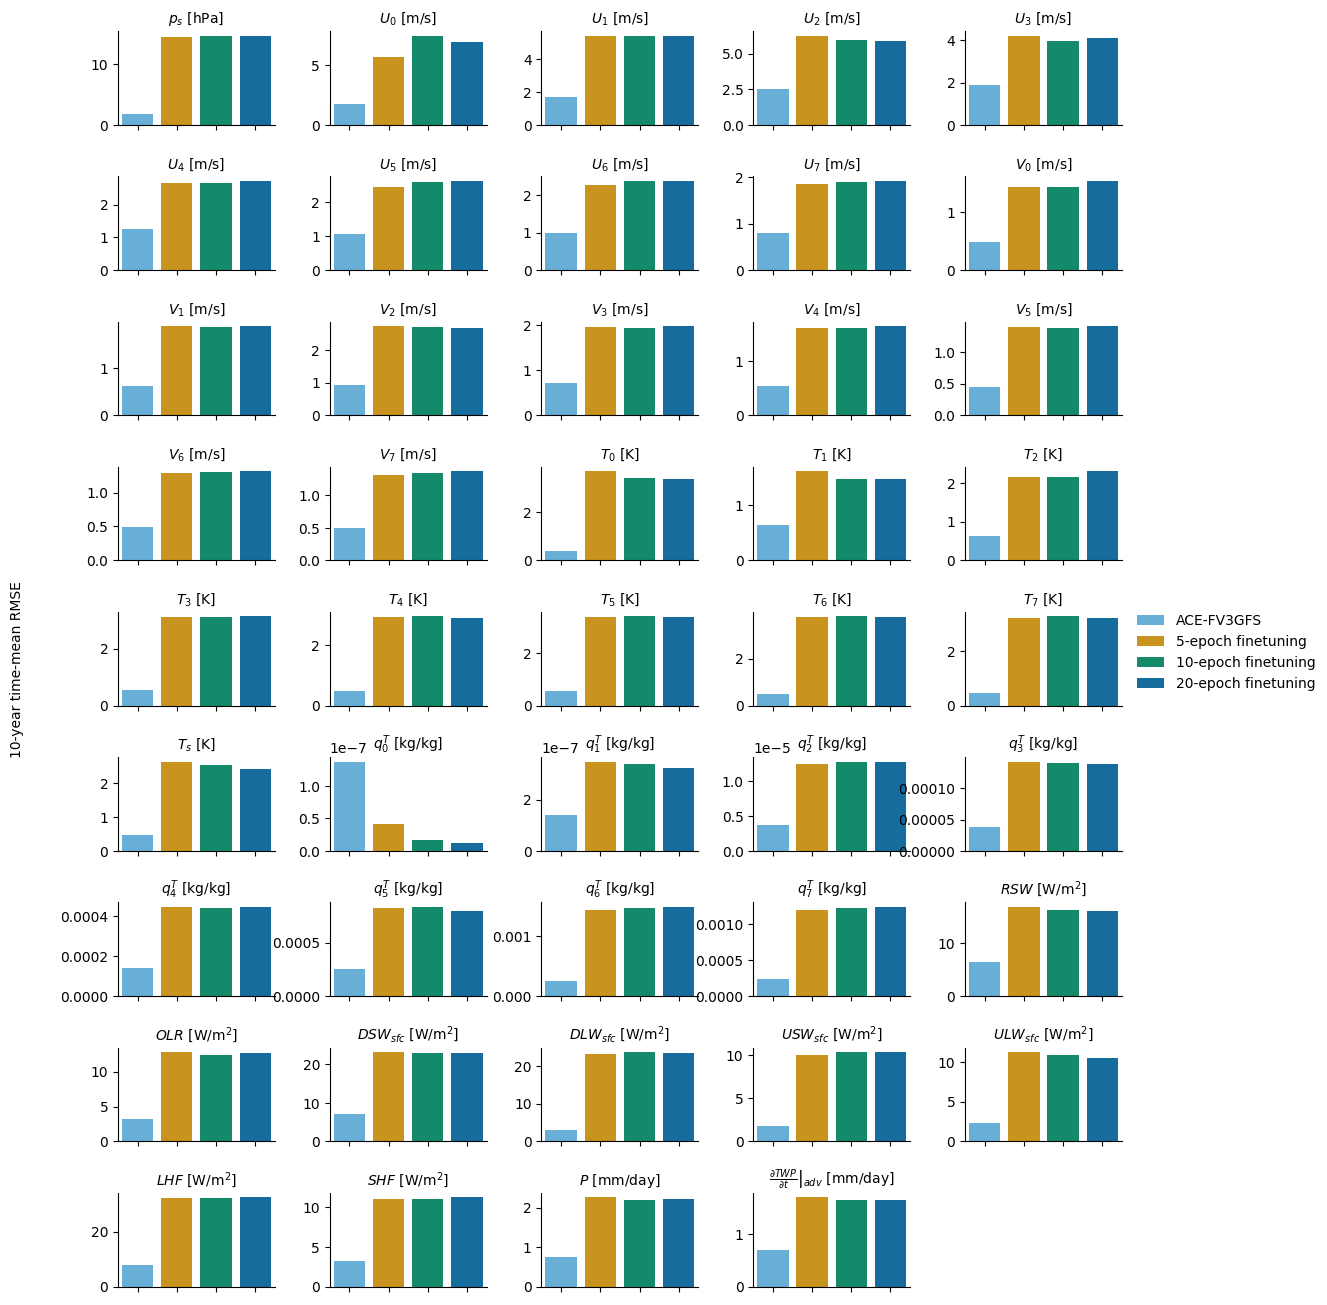

In [62]:
inf_df = inf_rmse_fv3_long.join(all_units, on="variable").join(
    pd.DataFrame.from_dict(all_vars, orient="index", columns=["title"]), 
    on="variable"
)
inf_df["title"] = inf_df["title"] + " [" + inf_df["units"] + "]"

g = sns.catplot(
    inf_df, kind="bar",
    x="run", y="value", col="title", hue="run", col_wrap=5,
    height=1.5, aspect=1.5, sharey=False, legend="full",
)

g.set_axis_labels("", "")
g.set_titles(col_template="{col_name}")

g.fig.text(0, 0.5, "10-year time-mean RMSE", 
           rotation="vertical", verticalalignment="center")

g._legend.set_title("")

g.set_xticklabels([])
g.figure.subplots_adjust(wspace=0.35, hspace=0.55)

plt.show()